In [2]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import cv2
import h5py
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

In [3]:
# mount drive
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

# project folder abosulte path
os.chdir('drive/MyDrive/project')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/project'

# Data Acquiring

save dataset to /dataset. Lower Resolution images in LR_train and LR_valid. Subfolders are X2, X3, X4. Higher Resolution images in HR_train and HR_train.

In [ ]:
# download and unzip files
# TODO
# %%bash
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X3.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X3.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
# wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
# unzip DIV2K_train_HR.zip -d dataset/
# unzip DIV2K_valid_HR.zip -d dataset/
# unzip DIV2K_train_LR_bicubic_X2.zip -d dataset/
# unzip DIV2K_train_LR_bicubic_X3.zip -d dataset/
# unzip DIV2K_train_LR_bicubic_X4.zip -d dataset/
# unzip DIV2K_valid_LR_bicubic_X2.zip -d dataset/
# unzip DIV2K_valid_LR_bicubic_X3.zip -d dataset/
# unzip DIV2K_valid_LR_bicubic_X4.zip -d dataset/

In [43]:
os.listdir('dataset')

['DIV2K_valid_HR',
 'DIV2K_valid_LR_bicubic',
 'DIV2K_train_LR_bicubic',
 '.ipynb_checkpoints',
 'DIV2K_train_HR',
 'train_x2.h5py',
 'valid_x2.h5py',
 'test_x2.h5py',
 'train_x3.h5py',
 'valid_x3.h5py',
 'test_x3.h5py',
 'train_x4.h5py',
 'valid_x4.h5py',
 'test_x4.h5py']

# EDA

(1644, 2040, 3)
(822, 1020, 3)
(548, 680, 3)
(411, 510, 3)


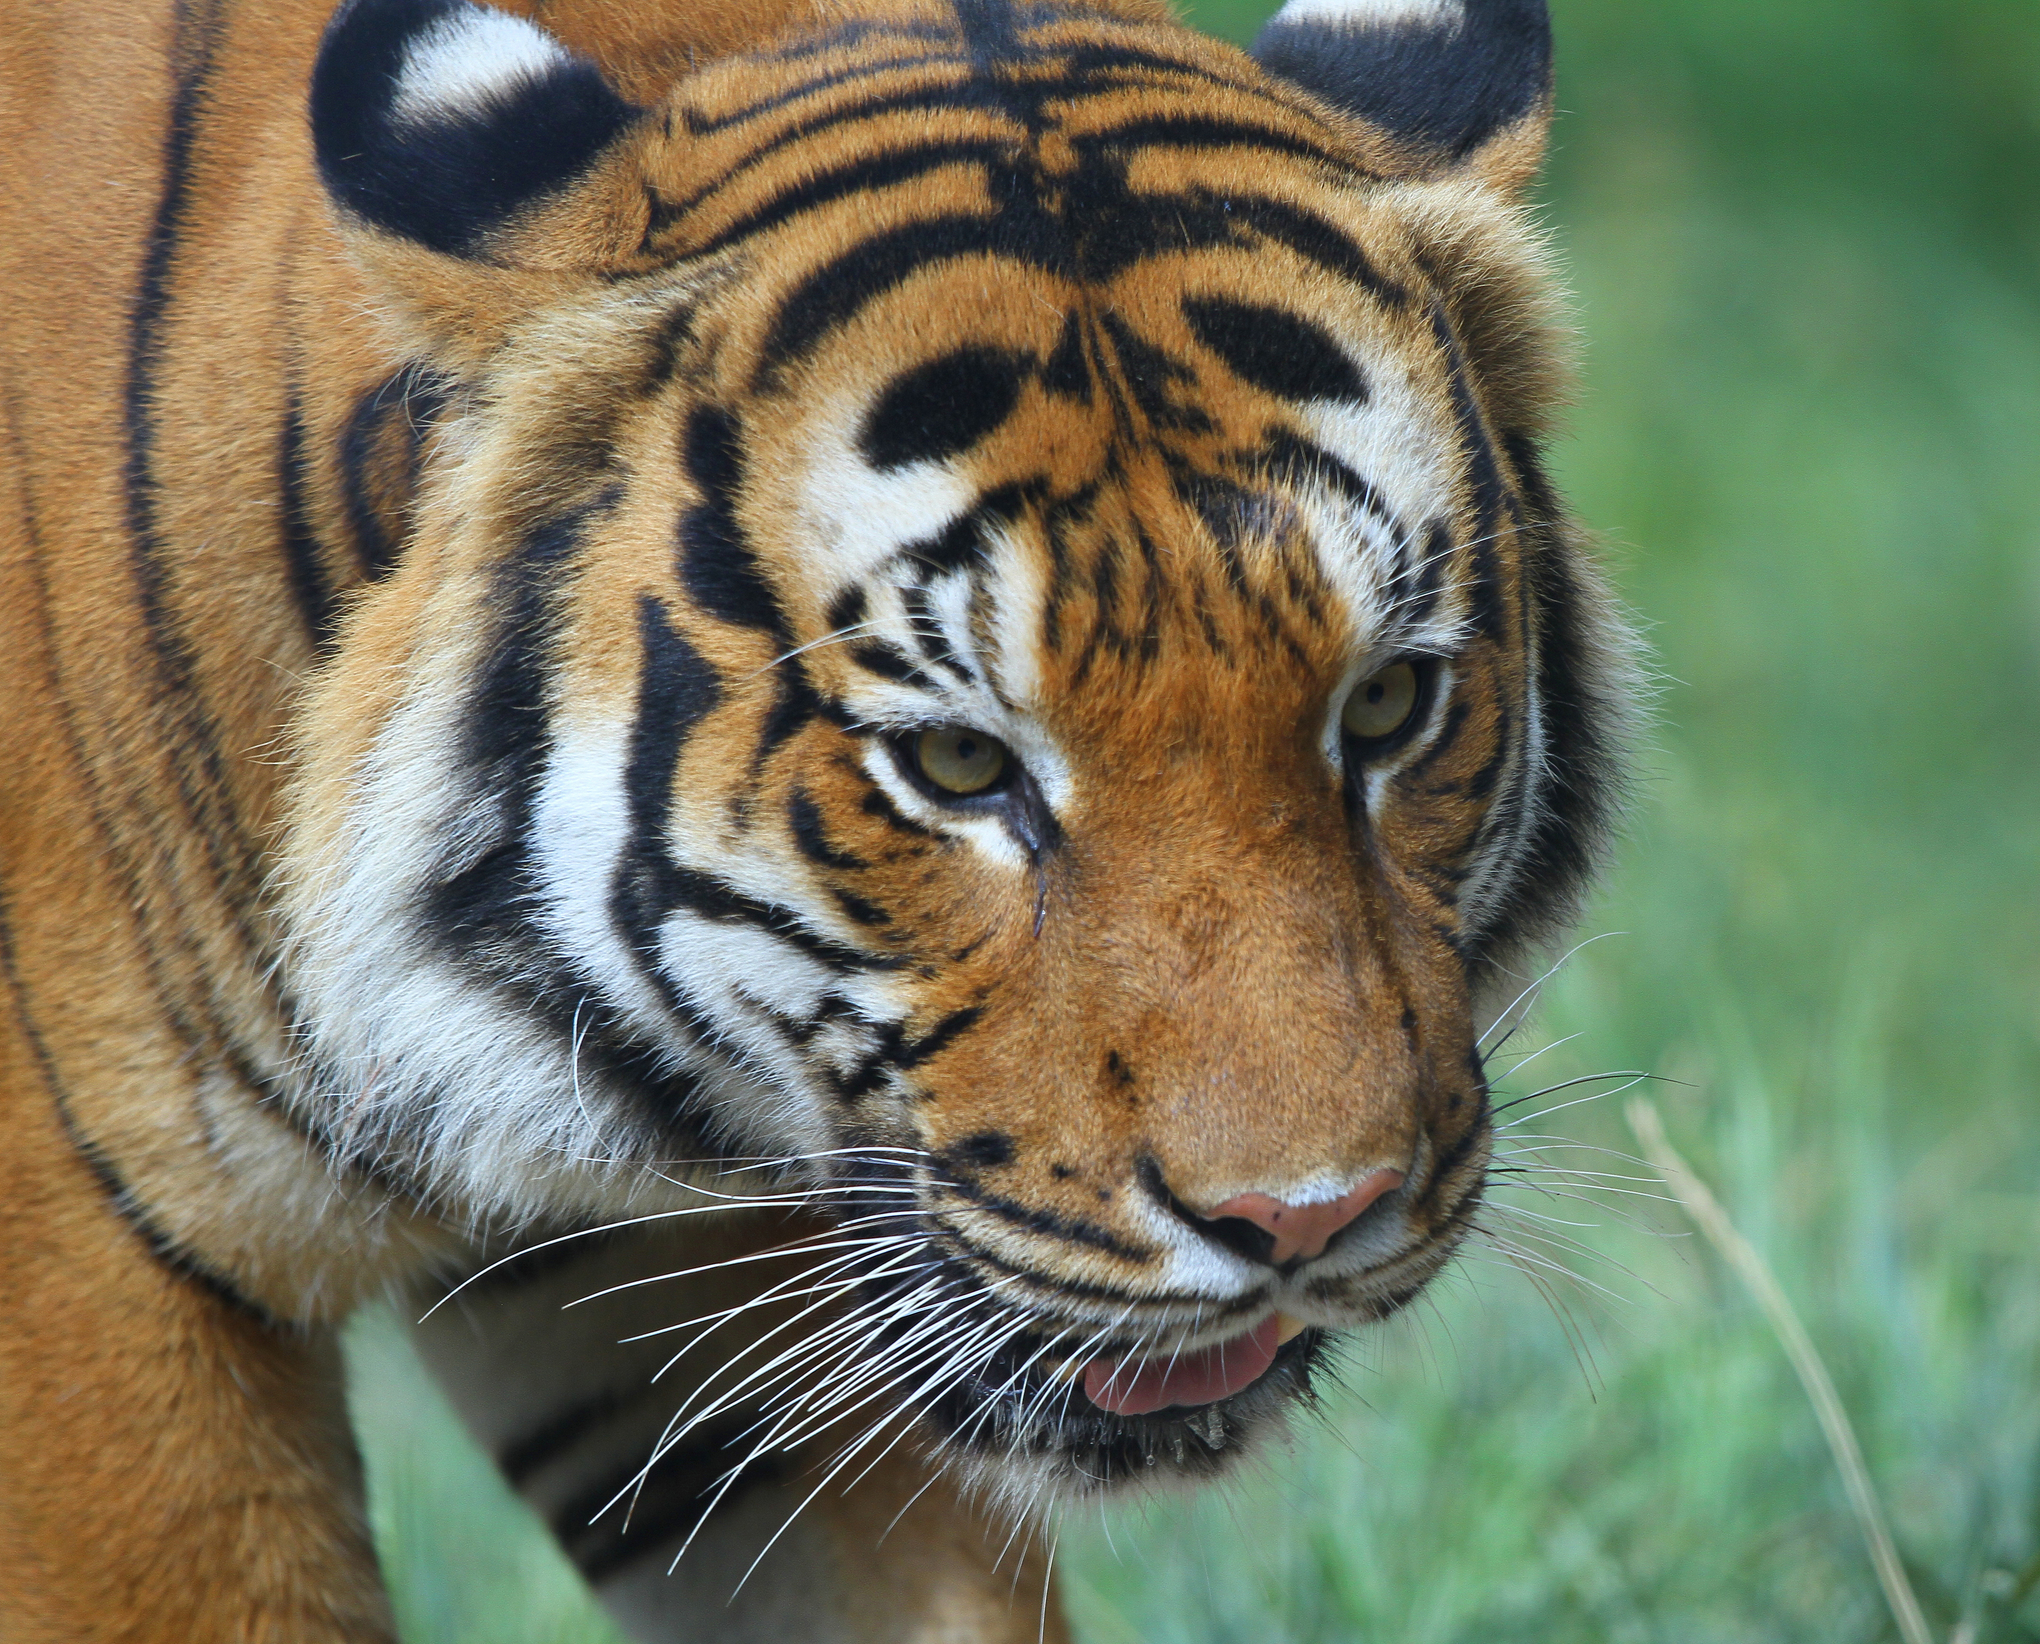

In [34]:
# display example image and their sizes
srcs = ['dataset/DIV2K_train_HR/', 'dataset/DIV2K_train_LR_bicubic/X2/',
       'dataset/DIV2K_train_LR_bicubic/X3/','dataset/DIV2K_train_LR_bicubic/X4/']
imgs = ['0010.png', '0010x2.png', '0010x3.png', '0010x4.png']

for i in range(len(srcs)):
    img = cv2.imread(srcs[i]+imgs[i])
    print(img.shape)

Image.open(srcs[0]+imgs[0])

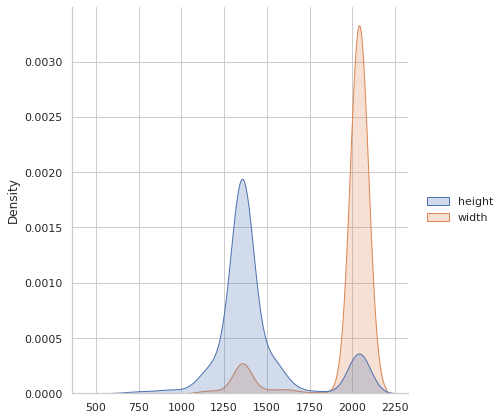

In [26]:
# distribution of image height and width
src = 'dataset/DIV2K_train_HR/'

hs, ws = [], []
for f in os.listdir(src):
    img = cv2.imread(src+f)
    # (height, width, channel)

    hs += [img.shape[0]]
    ws += [img.shape[1]]

df = pd.DataFrame({'height':hs, 'width':ws})
sns.set_style('whitegrid')
sns.displot(df, kind='kde',fill=True,height=6)
plt.savefig('1.jpg')
plt.show()

# Data Preprocessing

In [ ]:
def find_sizes(src):
    # function to find the minimum sizes of images in the input src folder
    # return (width, height)
    min_height, min_width = float('inf'), float('inf')
    for f in os.listdir(src):
        img = cv2.imread(src+f,cv2.IMREAD_UNCHANGED)
        if img.shape[0] < min_height:
            min_height = img.shape[0]
        elif img.shape[1] < min_width:
            min_width = img.shape[1]
    return min_width, min_height

def matching_pairs(lr_src,hr_src):
    # function to match the LR images and HR images
    print('matching pairs')
    lr = os.listdir(lr_src)
    hr = os.listdir(hr_src)
    lr.sort()
    hr.sort()
    for i in range(len(lr)):
        if lr[i][:-6] != hr[i][:-4]:
            print('img not matched! ' + lr[i])
    return lr, hr

In [11]:
def bgr2ycbcr_y(img, y=True):
    # img: input array in uint8 (BGR, not RGB!)
    # reference: https://sistenix.com/rgb2ycbcr.html
    # the returned data types is float64

    Y = (np.dot(img,[25.064,129.057,65.738]))/256+16

    if y:
        return Y
    else:
        Cb = (np.dot(img,[112.439,-74.494,-37.945]))/256+128
        Cr = (np.dot(img,[-18.285,-94.154,112.439]))/256+128

        new_img = np.zeros(img.shape)
        new_img[:,:,0] = Y
        new_img[:,:,1] = Cb
        new_img[:,:,2] = Cr
        return new_img

def convert_rgb_to_y(lr_src,hr_src,lr,hr,lr_size,hr_size):
    # convert all LR and HR images from RGB to YCbCr and extract the y-channel
    print('converting')
    imgs_lr, imgs_hr = [],[]

    # for lr images
    for f in lr:
        # return BGR in uint8
        img = cv2.imread(lr_src+f,cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, lr_size)
        img_y = bgr2ycbcr_y(img)/255
        imgs_lr += [torch.from_numpy(img_y)]
  
    # for hr images
    for f in hr:
        img = cv2.imread(hr_src+f,cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, hr_size)
        img_y = bgr2ycbcr_y(img)/255
        imgs_hr += [torch.from_numpy(img_y)]
  
    # returned y-channels float64
    return imgs_lr, imgs_hr

def save_h5py(lr, hr, name, lr_size, hr_size,length=800,train=False,name_val=None):
    print('saving')
    # lr_size, hr_size: (width, height)
    # should be stored in (height, width)?
    db = h5py.File(name,'w')

    # lr_size = (width, height)
    if train:
        db_lr = db.create_dataset('lr',(length-100,lr_size[1],lr_size[0]),dtype='float32')
        db_hr = db.create_dataset('hr',(length-100,hr_size[1],hr_size[0]),dtype='float32')

        for i in range(len(lr[:-100])):
            db_lr[i] = lr[i]
            db_hr[i] = hr[i]
        db.close()
        print('file is saved at {}'.format(name))
    
        db_v = h5py.File(name_val,'w')
        db_lr_v = db_v.create_dataset('lr',(100,lr_size[1],lr_size[0]),dtype='float32')
        db_hr_v = db_v.create_dataset('hr',(100,hr_size[1],hr_size[0]),dtype='float32')

        a = np.arange(0,100)
        b = np.arange(700,800)
        for x,y in zip(a,b):
            db_lr_v[x] = lr[y]
            db_hr_v[x] = hr[y]
        db_v.close()
        print('file is saved at {}'.format(name_val))

    else:
        db_lr = db.create_dataset('lr',(length,lr_size[1],lr_size[0]),dtype='float32')
        db_hr = db.create_dataset('hr',(length,hr_size[1],hr_size[0]),dtype='float32')
        for i in range(len(lr)):
            db_lr[i] = lr[i]
            db_hr[i] = hr[i]
        db.close()
        print('file is saved at {}'.format(name))

In [ ]:
def preprocess(lr_src,hr_src,h5file,x=2,h5file_val=None,lr_sizes=None,hr_sizes=None):
    returned = False
    if lr_sizes is None or hr_sizes is None:
        # compute sizes for images
        print('width, height')
        lr_sizes = find_sizes(lr_src)
        print(lr_sizes)

        # hr sizes
        hr_sizes = (int(lr_sizes[0]*x), int(lr_sizes[1]*x))
        print(hr_sizes)
        returned = True

    # convert images
    lr,hr = matching_pairs(lr_src,hr_src)
    lr_train,hr_train = convert_rgb_to_y(lr_src,hr_src,lr,hr,lr_sizes,hr_sizes)

    # save in h5 format
    # (lr, hr, name, lr_size, hr_size,length=800,train=False,name_val=None)
    if h5file_val is not None:
        save_h5py(lr_train,hr_train,h5file, lr_sizes, hr_sizes, len(lr_train),train=True,name_val=h5file_val)
    else:
        save_h5py(lr_train,hr_train,h5file, lr_sizes, hr_sizes, len(lr_train))
  

    if returned:
        return (lr_sizes, hr_sizes)

In [ ]:
# prepare data for x2 type
lr_s2, hr_s2 = preprocess('dataset/DIV2K_train_LR_bicubic/X2/','dataset/DIV2K_train_HR/',
                          'dataset/train_x2.h5py',x=2,h5file_val='dataset/valid_x2.h5py')
preprocess('dataset/DIV2K_valid_LR_bicubic/X2/','dataset/DIV2K_valid_HR/',
           'dataset/test_x2.h5py', x=2,lr_sizes=lr_s2,hr_sizes=hr_s2)

width, height
(558, 324)
(1116, 648)
matching pairs
converting
saving
file is saved at dataset/train_x2.h5py
file is saved at dataset/valid_x2.h5py
matching pairs
converting
saving
file is saved at dataset/test_x2.h5py


In [ ]:
# prepare data for x3 type
lr_s3, hr_s3 = preprocess('dataset/DIV2K_train_LR_bicubic/X3/','dataset/DIV2K_train_HR/',
                          'dataset/train_x3.h5py',x=3,h5file_val='dataset/valid_x3.h5py')
preprocess('dataset/DIV2K_valid_LR_bicubic/X3/','dataset/DIV2K_valid_HR/',
           'dataset/test_x3.h5py',x=3,lr_sizes=lr_s3,hr_sizes=hr_s3)

width, height
(372, 216)
(1116, 648)
matching pairs
converting
saving
file is saved at dataset/train_x3.h5py
file is saved at dataset/valid_x3.h5py
matching pairs
converting
saving
file is saved at dataset/test_x3.h5py


In [ ]:
# prepare data for x4 type
lr_s4, hr_s4 = preprocess('dataset/DIV2K_train_LR_bicubic/X4/','dataset/DIV2K_train_HR/',
                          'dataset/train_x4.h5py',x=4,h5file_val='dataset/valid_x4.h5py')
preprocess('dataset/DIV2K_valid_LR_bicubic/X4/','dataset/DIV2K_valid_HR/',
           'dataset/test_x4.h5py',x=4,lr_sizes=lr_s4,hr_sizes=hr_s4)

width, height
(279, 162)
(1116, 648)
matching pairs
converting
saving
file is saved at dataset/train_x4.h5py
file is saved at dataset/valid_x4.h5py
matching pairs
converting
saving
file is saved at dataset/test_x4.h5py


# Dataloader

In [11]:
# source: https://github.com/yjn870/FSRCNN-pytorch/blob/master/datasets.py
class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][idx], 0), np.expand_dims(f['hr'][idx], 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])


# Model Building

In [10]:
class fsrcnn(nn.Module):
    # reference: https://towardsdatascience.com/review-fsrcnn-super-resolution-80ca2ee14da4
    def __init__(self,d,s,m,x):
        super(fsrcnn, self).__init__()
        self.x = x

        # Conv(f,n,c): f = fxf filter size, n = #filters, c = #input channels

        # feature extraction: Conv(5,d,1)
        self.feat_extrac = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=d,kernel_size=5),
            nn.PReLU(d)
        )
    
        # shrinking: Conv(1,s,d)
        self.shrink = nn.Sequential(
            nn.Conv2d(in_channels=d,out_channels=s,kernel_size=1),
            nn.PReLU(s)
        )

        # mapping for m times: Conv(3,s,s)
        self.mapping = nn.Sequential()
        for i in range(m):
            self.mapping.add_module('map_{}'.format(i), nn.Conv2d(in_channels=s,
                                                            out_channels=s,
                                                            kernel_size=3))
            self.mapping.add_module('map_prelu_{}'.format(i),nn.PReLU(s))

    
        # expanding: Conv(1,d,s)
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels=s,out_channels=d,kernel_size=1),
            nn.PReLU(d)
        )

        self.DeConvolution(d)

        # TODO: initial weights?

    def DeConvolution(self,d):
        if self.x == 2:
            # deconvolution: DeConv(9,1,s)
            # out_channels = number of the image channel, 1 for this project
            # # m = 2
            # self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,
            #                                  kernel_size=9,stride=self.x,dilation=2,output_padding=1)
            # m = 3
            self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,padding=2,
                                            kernel_size=9,stride=self.x,dilation=3,output_padding=1)
            # # m = 4
            # self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,
            #                                 kernel_size=9,stride=self.x,dilation=3,output_padding=1)
        elif self.x == 3:
            # m = 3
            self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,
                                            kernel_size=9,stride=self.x,dilation=4)
            # # m = 4
            # self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,padding=1,
            #                                 kernel_size=9,stride=self.x,dilation=5)
        else:
            # # m = 4 
            # self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,output_padding=3,
            #                                  kernel_size=9,stride=self.x,dilation=6)
            # m = 1
            self.deconv = nn.ConvTranspose2d(in_channels=d,out_channels=1,output_padding=3,
                                            kernel_size=9,stride=self.x,dilation=3)


    def forward(self,x):
        x = self.shrink(self.feat_extrac(x))
        x = self.mapping(x)
        x = self.expand(x)
        x = self.deconv(x)
        return x

# Model Training

In [4]:
def PSNR(mse):
    if(mse == 0):
        return 100
    return 10*np.log10((1**2)/mse)

In [5]:
def train_model(datafile,x,params):
    # components for the training process
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = fsrcnn(d=params['d'],s=params['s'],m=params['m'],x=x).to(device)
    criterion = nn.MSELoss().to(device)
    loader_train = DataLoader(dataset=TrainDataset(datafile),batch_size=params['batch'],shuffle=True)
    optimizer = optim.Adam([{'params':model.feat_extrac.parameters()},
                            {'params':model.shrink.parameters()},
                            {'params':model.mapping.parameters()},
                            {'params':model.expand.parameters()},
                            {'params':model.deconv.parameters()}
                            ], lr=params['lr'])
  
    # run epochs
    mse_loss, psnr = [], []
    for epoch in np.arange(0,params['epochs']):
        model.train()

        for row in loader_train:
            # read data and move it to GPU
            lr, hr = row
            lr, hr = lr.to(device,non_blocking=True), hr.to(device,non_blocking=True)

            # forward pass
            outputs = model(lr)
            loss = criterion(outputs,hr)

            # backprop
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()
        mse_loss  += [loss.item()]
        psnr += [PSNR(loss.item())]

    return mse_loss, psnr, model

In [6]:
def test_model(model,datafile,params):
    loader_valid = DataLoader(dataset=TrainDataset(datafile),batch_size=params['batch'])
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mse = nn.MSELoss().to(device)
    mse_loss,psnr = [],[]

    with torch.no_grad():
        for lr, hr in loader_valid:
            lr, hr = lr.to(device,non_blocking=True), hr.to(device,non_blocking=True)
            model.eval()
            outputs = model(lr)

            # metrics
            loss = mse(outputs,hr)
            mse_loss  += [loss.item()]
            psnr += [PSNR(loss.item())]

    return mse_loss, psnr

In [7]:
params_x2 = {'lr':0.001,'epochs':50,'d':40,'s':15,'m':3,'batch':30}
params_x3 = {'lr':0.001,'epochs':50,'d':25,'s':20,'m':3,'batch':30}
params_x4 = {'lr':0.001,'epochs':50,'d':40,'s':15,'m':1,'batch':30}

In [ ]:
# torch.cuda.empty_cache()

In [12]:
mse_train_x2, psnr_train_x2, model_x2 = train_model('dataset/train_x2.h5py',2,params_x2)
mse_valid_x2, psnr_valid_x2 = test_model(model_x2,'dataset/valid_x2.h5py',params_x2)

mse_train_x3, psnr_train_x3, model_x3 = train_model('dataset/train_x3.h5py',3,params_x3)
mse_valid_x3, psnr_valid_x3 = test_model(model_x3,'dataset/valid_x3.h5py',params_x3)

mse_train_x4, psnr_train_x4, model_x4 = train_model('dataset/train_x4.h5py',4,params_x4)
mse_valid_x4, psnr_valid_x4 = test_model(model_x4,'dataset/valid_x4.h5py',params_x4)

# Evaluation

In [44]:
def plot_mse_psnr(mse,psnr,kind):
    epochs = np.arange(len(mse))
    plt.figure(figsize=(9,6))
    plt.plot(epochs,mse)
    plt.xlabel('# of epochs')
    plt.ylabel('MSE per batch')
    plt.title('{} MSE'.format(kind))
    plt.savefig('{}_MSE.jpg'.format(kind))
    plt.show()

    plt.figure(figsize=(9,6))
    plt.plot(epochs,psnr)
    plt.xlabel('# of epochs')
    plt.ylabel('PSNR per batch')
    plt.title('{} PSNR'.format(kind))
    plt.savefig('{}_PSNR.jpg'.format(kind))
    plt.show()

## X2

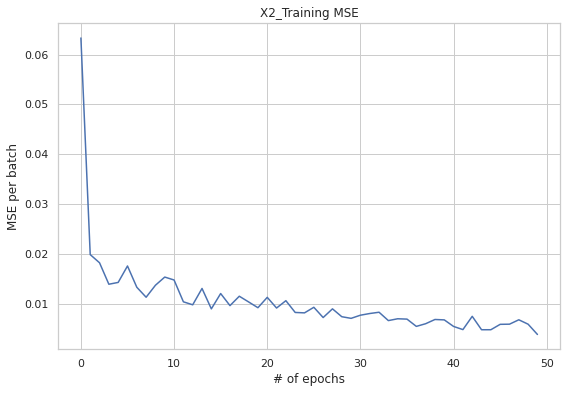

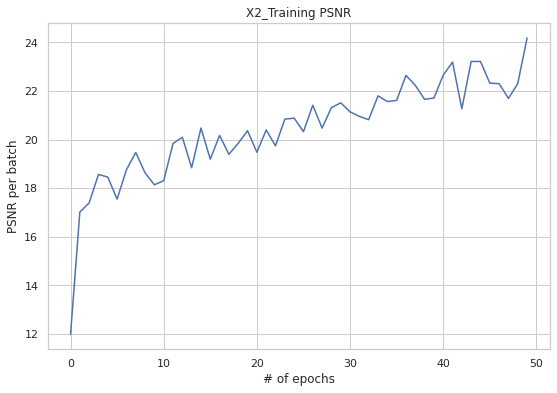

avg. valid. MSE for x2: 0.004537303815595806
avg. valid. PSNR for x2: 23.448896080319336


In [46]:
plot_mse_psnr(mse_train_x2,psnr_train_x2,'X2_Training')
print('avg. valid. MSE for x2: {}'.format(np.mean(mse_valid_x2)))
print('avg. valid. PSNR for x2: {}'.format(np.mean(psnr_valid_x2)))

In [47]:
mse_test_x2, psnr_test_x2 = test_model(model_x2,'dataset/test_x2.h5py',params_x2)
print('avg. test MSE for x2: {}'.format(np.mean(mse_test_x2)))
print('avg. test PSNR for x2: {}'.format(np.mean(psnr_test_x2)))

avg. test MSE for x2: 0.005453730118460953
avg. test PSNR for x2: 22.669516214200858


## X3

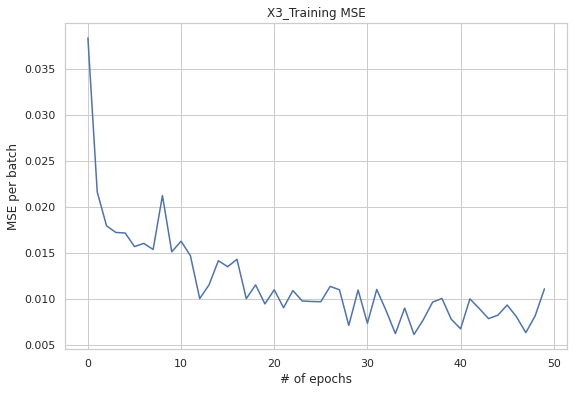

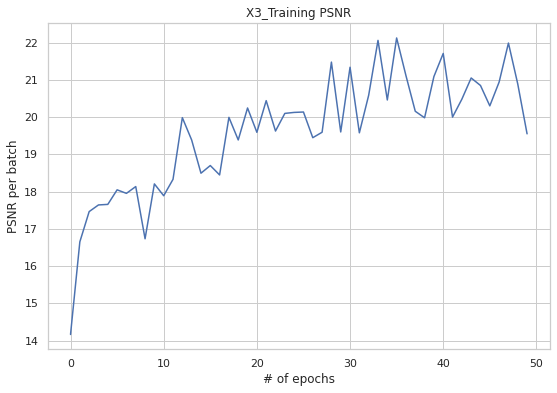

avg. valid. MSE for x3: 0.0064759282395243645
avg. valid. PSNR for x3: 21.904233160188422


In [48]:
plot_mse_psnr(mse_train_x3,psnr_train_x3,'X3_Training')
print('avg. valid. MSE for x3: {}'.format(np.mean(mse_valid_x3)))
print('avg. valid. PSNR for x3: {}'.format(np.mean(psnr_valid_x3)))

In [49]:
mse_test_x3, psnr_test_x3 = test_model(model_x3,'dataset/test_x3.h5py',params_x3)
print('avg. test MSE for x3: {}'.format(np.mean(mse_test_x3)))
print('avg. test PSNR for x3: {}'.format(np.mean(psnr_test_x3)))

avg. test MSE for x3: 0.008011212688870728
avg. test PSNR for x3: 21.016710083970743


## X4

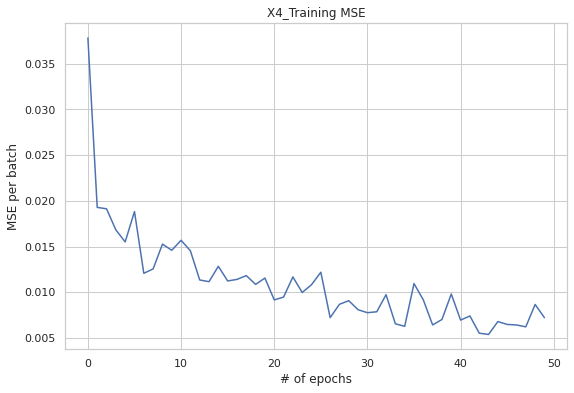

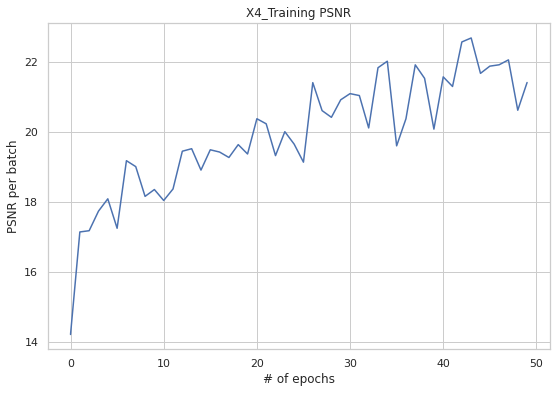

avg. valid. MSE for x4: 0.005906085832975805
avg. valid. PSNR for x4: 22.304394340689086


In [50]:
plot_mse_psnr(mse_train_x4,psnr_train_x4,'X4_Training')
print('avg. valid. MSE for x4: {}'.format(np.mean(mse_valid_x4)))
print('avg. valid. PSNR for x4: {}'.format(np.mean(psnr_valid_x4)))

In [51]:
mse_test_x4, psnr_test_x4 = test_model(model_x4,'dataset/test_x4.h5py',params_x4)
print('avg. test MSE for x4: {}'.format(np.mean(mse_test_x4)))
print('avg. test PSNR for x4: {}'.format(np.mean(psnr_test_x4)))

avg. test MSE for x4: 0.007216586614958942
avg. test PSNR for x4: 21.459401643430464


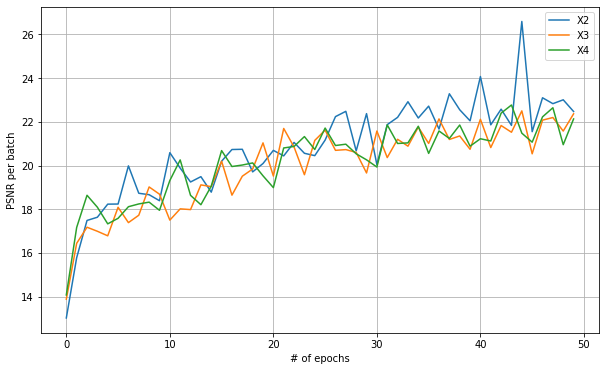

In [16]:
epochs = np.arange(0,50)
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(epochs, psnr_train_x2, label='X2')
plt.plot(epochs, psnr_train_x3, label='X3')
plt.plot(epochs, psnr_train_x4, label='X4')
plt.legend()
plt.xlabel('# of epochs'), plt.ylabel('PSNR per batch')
plt.show()